In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n' .join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 20 18:59:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Problem 1 - Transfer learning: Shallow learning vs Finetuning, Pytorch 30 points
In this problem we will train a convolutional neural network for image classification using transfer learning.
Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K
with 1.2 M images and 1K categories) and then using this base network either as a feature extractor or as
an initialization network for target task. Thus two major transfer learning scenarios are as follows:
•Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained
network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however
the learning rate schedule for transfer learning may be different.
•Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except
that of the final fully connected layer. This last fully connected layer is replaced with a new one with
random weights and only this layer is trained.
### 1. For fine-tuning you will select a target dataset from the Visual-Decathlon challenge. Their web site (link below) has several datasets which you can download. Select any one of the visual decathlon dataset and make it your target dataset for transfer learning. Important : Do not select Imagenet1K as the target dataset.
#### (a) Finetuning: You will first load a pretrained model (Resnet50) and change the final fully connected layer output to the number of classes in the target dataset. Describe your target dataset features, number of classes and distribution of images per class (i.e., number of images per class). Show any 4 sample images (belonging to 2 different classes) from your target dataset. (2+2)

In [ ]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 64

trainset = torchvision.datasets.FGVCAircraft(root='./data', split='trainval',
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FGVCAircraft(root='./data', split='test',
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting ./data/fgvc-aircraft-2013b.tar.gz to ./data


Target data set: FGVCAircraft </br>
Features: 10,000 images of airplanes. Models partitioned into a hierarchy: model (e.g Boeing 737-76J), variant(Boeing 737-700), family (Boeing 737), manufacturer (Boeing).</br>
Classes: 100, Aircraft models</br>
Images per class: 100





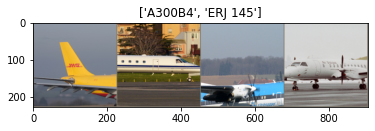

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

class_names = trainset.classes
dataiter = iter(trainloader)
inputs, classes  = next(dataiter)

out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[0:2]])

####(b) First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 200-300 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 (γ = 0.1 in the link below). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 200 epochs, first drop can happen at epoch 60, second at epoch 120 and third at epoch 180. (8)

In [ ]:
dataloaders={'train':trainloader,'val':testloader}
dataset_sizes = {'train': len(trainset), 'val':len(testset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return (model,time_elapsed // 60,best_acc)

In [ ]:
accuracies=[]
model,time_train,accuracy = train_model(model,nn.CrossEntropyLoss(), optimizer, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 4.6128 Acc: 0.0159
val Loss: 4.5196 Acc: 0.0387

Epoch 1/199
----------
train Loss: 4.4813 Acc: 0.0531
val Loss: 4.3706 Acc: 0.0984

Epoch 2/199
----------
train Loss: 4.3096 Acc: 0.1077
val Loss: 4.1644 Acc: 0.1287

Epoch 3/199
----------
train Loss: 4.0847 Acc: 0.1401
val Loss: 3.9018 Acc: 0.1731

Epoch 4/199
----------
train Loss: 3.8330 Acc: 0.1878
val Loss: 3.6154 Acc: 0.2067

Epoch 5/199
----------
train Loss: 3.6119 Acc: 0.2331
val Loss: 3.4192 Acc: 0.2496

Epoch 6/199
----------
train Loss: 3.4144 Acc: 0.2612
val Loss: 3.2022 Acc: 0.2697

Epoch 7/199
----------
train Loss: 3.2188 Acc: 0.3008
val Loss: 2.9855 Acc: 0.3087

Epoch 8/199
----------
train Loss: 3.0367 Acc: 0.3251
val Loss: 2.8234 Acc: 0.3297

Epoch 9/199
----------
train Loss: 2.8559 Acc: 0.3509
val Loss: 2.6497 Acc: 0.3609

Epoch 10/199
----------
train Loss: 2.6999 Acc: 0.3854
val Loss: 2.4728 Acc: 0.3852

Epoch 11/199
----------
train Loss: 2.5513 Acc: 0.4130
val Loss: 2.3708 Acc

In [ ]:
accuracy

tensor(0.6997, device='cuda:0', dtype=torch.float64)

#### (c) Next keeping all the hyperparameters (including multi-step learning rate schedule) same as before, change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model, using the same mutli-step learning rate schedule as in Part (b), and report the final accuracy. How does the accuracy with the three learning rates compare ? Which learning rate gives you the best accuracy on the target dataset ? (6)

In [ ]:
model2 = models.resnet50(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 100)
model2 = model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
model2,time_train2,accuracy2 = train_model(model2,nn.CrossEntropyLoss(), optimizer, exp_lr_scheduler,
                       num_epochs=200)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/199
----------
train Loss: 3.7591 Acc: 0.1266
val Loss: 2.5013 Acc: 0.2973

Epoch 1/199
----------
train Loss: 2.3265 Acc: 0.3505
val Loss: 2.0423 Acc: 0.4362

Epoch 2/199
----------
train Loss: 1.8173 Acc: 0.4597
val Loss: 1.4019 Acc: 0.5545

Epoch 3/199
----------
train Loss: 1.5779 Acc: 0.5241
val Loss: 1.4872 Acc: 0.5464

Epoch 4/199
----------
train Loss: 1.3358 Acc: 0.5922
val Loss: 1.2832 Acc: 0.6085

Epoch 5/199
----------
train Loss: 1.2391 Acc: 0.6201
val Loss: 0.8836 Acc: 0.7021

Epoch 6/199
----------
train Loss: 1.1553 Acc: 0.6457
val Loss: 0.7478 Acc: 0.7465

Epoch 7/199
----------
train Loss: 1.0802 Acc: 0.6720
val Loss: 0.8007 Acc: 0.7330

Epoch 8/199
----------
train Loss: 0.9973 Acc: 0.6846
val Loss: 0.6978 Acc: 0.7552

Epoch 9/199
----------
train Loss: 0.9152 Acc: 0.7176
val Loss: 0.6839 Acc: 0.7630

Epoch 10/199
----------
train Loss: 0.9150 Acc: 0.7234
val Loss: 0.4396 Acc: 0.8503

Epoch 11/199
----------
train Loss: 0.8174 Acc: 0.7495
val Loss: 0.4082 Acc

KeyboardInterrupt: ignored

In [ ]:
model3 = models.resnet50(pretrained=True)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 100)
model3 = model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
model3 = train_model(model3,nn.CrossEntropyLoss(), optimizer, exp_lr_scheduler,
                       num_epochs=200)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/199
----------
train Loss: 4.7482 Acc: 0.0112
val Loss: 4.5705 Acc: 0.0195

Epoch 1/199
----------
train Loss: 4.5687 Acc: 0.0184
val Loss: 4.5173 Acc: 0.0180

Epoch 2/199
----------
train Loss: 4.5224 Acc: 0.0174
val Loss: 4.4762 Acc: 0.0249

Epoch 3/199
----------
train Loss: 4.4667 Acc: 0.0217
val Loss: 4.5727 Acc: 0.0318

Epoch 4/199
----------
train Loss: 4.4119 Acc: 0.0319
val Loss: 4.4170 Acc: 0.0360

Epoch 5/199
----------
train Loss: 4.3789 Acc: 0.0393
val Loss: 4.3350 Acc: 0.0372

Epoch 6/199
----------
train Loss: 4.2981 Acc: 0.0405
val Loss: 4.3039 Acc: 0.0495

Epoch 7/199
----------
train Loss: 4.2034 Acc: 0.0508
val Loss: 4.7794 Acc: 0.0396

Epoch 8/199
----------
train Loss: 4.1028 Acc: 0.0577
val Loss: 4.2345 Acc: 0.0498

Epoch 9/199
----------
train Loss: 3.9904 Acc: 0.0651
val Loss: 4.1998 Acc: 0.0603

Epoch 10/199
----------
train Loss: 3.8311 Acc: 0.0852
val Loss: 3.9937 Acc: 0.0663

Epoch 11/199
----------
train Loss: 3.7015 Acc: 0.0985
val Loss: 4.2341 Acc

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    AssertionErrorif w.is_alive():
  File "

train Loss: 0.5747 Acc: 0.8413


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.9203 Acc: 0.7339

Epoch 64/199
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.5472 Acc: 0.8523


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

AssertionError:     if w.is_alive():can only test a child process

  File "/usr/lib/pytho

val Loss: 0.9196 Acc: 0.7360

Epoch 65/199
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>self._shutdown_workers()

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():        assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.7/multiprocessing/process.py"

train Loss: 0.5361 Acc: 0.8494


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f651a585440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.8979 Acc: 0.7459

Epoch 66/199
----------
train Loss: 0.5276 Acc: 0.8536
val Loss: 0.9002 Acc: 0.7441

Epoch 67/199
----------
train Loss: 0.5094 Acc: 0.8583
val Loss: 0.9118 Acc: 0.7438

Epoch 68/199
----------
train Loss: 0.5237 Acc: 0.8529
val Loss: 0.9019 Acc: 0.7498

Epoch 69/199
----------
train Loss: 0.4931 Acc: 0.8625
val Loss: 0.9040 Acc: 0.7459

Epoch 70/199
----------
train Loss: 0.5062 Acc: 0.8608
val Loss: 0.9099 Acc: 0.7441

Epoch 71/199
----------
train Loss: 0.5129 Acc: 0.8586
val Loss: 0.8986 Acc: 0.7561

Epoch 72/199
----------
train Loss: 0.4685 Acc: 0.8677
val Loss: 0.9142 Acc: 0.7534

Epoch 73/199
----------
train Loss: 0.4853 Acc: 0.8646
val Loss: 0.9249 Acc: 0.7468

Epoch 74/199
----------
train Loss: 0.4773 Acc: 0.8706
val Loss: 0.9174 Acc: 0.7504

Epoch 75/199
----------
train Loss: 0.4727 Acc: 0.8697
val Loss: 0.9348 Acc: 0.7492

Epoch 76/199
----------
train Loss: 0.4728 Acc: 0.8688
val Loss: 0.9295 Acc: 0.7474

Epoch 77/199
----------
train Loss:

In [ ]:
lrs=[0.1,0.01,0.001]
for x in range(len(accuracies)):
  print("Learning rate: ",lrs[x],"   - Accuracy: ",accuracies[x])

In [ ]:
[model3[2]]

[tensor(0.7672, device='cuda:0', dtype=torch.float64)]

##### Results: </br>
------------------------------
lr=0.001 </br>
Best val Acc: 0.699670 </br>
 </br>
lr=0.01 </br>
Best val Acc: N/A*** </br>
 </br>
lr=0.1 </br>
Best val Acc: 0.767177 </br>


------------------------------
The accuracy improves as the learning rate increases. The best accuracy is achieved by setting the learning rate equal to 0.1, at 0.767177.</br>

*** trained for 100 epochs, realized "trainval" was used for the training set and "val" was used for the test set for FGVCAircraft. It achieved 100% accuracy and I aborted it. For both of the other learning rates, the correct data sets for training and testing were used.</br>

### 2. When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.

#### (a) Now train only the last layer for 1, 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset ? (8)

In [ ]:
accuracies=[]
models=[]
times=[]
lrs=[1, 0.1]
for x in lrs:
  print("lr:",x)
  model = torchvision.models.resnet50(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 100)
  optimizer = optim.SGD(model.fc.parameters(), lr=x, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
  model = model.to(device)
  model4,time_train4,accuracy4  = train_model(model, nn.CrossEntropyLoss(), optimizer,
                          exp_lr_scheduler, num_epochs=200)
  accuracies=accuracies+[accuracy4]
  models=models+[model4]
  times=times+[time_train4]

lr: 1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/199
----------
train Loss: 407.8512 Acc: 0.0492
val Loss: 193.4935 Acc: 0.0921

Epoch 1/199
----------
train Loss: 105.3532 Acc: 0.1462
val Loss: 88.7682 Acc: 0.1470

Epoch 2/199
----------
train Loss: 87.0745 Acc: 0.1945
val Loss: 84.3002 Acc: 0.1848

Epoch 3/199
----------
train Loss: 64.3139 Acc: 0.2301
val Loss: 61.0989 Acc: 0.2151

Epoch 4/199
----------
train Loss: 60.3943 Acc: 0.2404
val Loss: 79.8248 Acc: 0.1797

Epoch 5/199
----------
train Loss: 61.5797 Acc: 0.2476
val Loss: 74.0936 Acc: 0.2073

Epoch 6/199
----------
train Loss: 59.2956 Acc: 0.2731
val Loss: 67.8977 Acc: 0.2382

Epoch 7/199
----------
train Loss: 55.2930 Acc: 0.2833
val Loss: 62.8316 Acc: 0.2370

Epoch 8/199
----------
train Loss: 58.6714 Acc: 0.2770
val Loss: 74.1238 Acc: 0.2358

Epoch 9/199
----------
train Loss: 55.7517 Acc: 0.2976
val Loss: 69.4284 Acc: 0.2379

Epoch 10/199
----------
train Loss: 52.1685 Acc: 0.3081
val Loss: 57.5742 Acc: 0.2649

Epoch 11/199
----------
train Loss: 50.4879 Acc: 0

In [ ]:
lrs=[0.01]
for x in lrs:
  print("lr:",x)
  model = torchvision.models.resnet50(pretrained=True)
  #[param.requires_grad = False for x in model.parameters()]
  for param in model.parameters():
    param.requires_grad = False
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 100)
  optimizer = optim.SGD(model.fc.parameters(), lr=x, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
  model = model.to(device)
  model4,time_train4,accuracy4  = train_model(model, nn.CrossEntropyLoss(), optimizer,
                          exp_lr_scheduler, num_epochs=200)
  accuracies=accuracies+[accuracy4]
  models=models+[model4]
  times=times+[time_train4]

lr: 0.01


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/199
----------
train Loss: 4.3954 Acc: 0.0592
val Loss: 3.9539 Acc: 0.1182

Epoch 1/199
----------
train Loss: 3.7384 Acc: 0.1657
val Loss: 3.4412 Acc: 0.2040

Epoch 2/199
----------
train Loss: 3.3702 Acc: 0.2337
val Loss: 3.1930 Acc: 0.2589

Epoch 3/199
----------
train Loss: 3.1629 Acc: 0.2655
val Loss: 3.0631 Acc: 0.2700

Epoch 4/199
----------
train Loss: 2.9650 Acc: 0.3030
val Loss: 2.9213 Acc: 0.2934

Epoch 5/199
----------
train Loss: 2.8601 Acc: 0.3201
val Loss: 2.8233 Acc: 0.3036

Epoch 6/199
----------
train Loss: 2.7407 Acc: 0.3375
val Loss: 2.7410 Acc: 0.3402

Epoch 7/199
----------
train Loss: 2.6507 Acc: 0.3573
val Loss: 2.7287 Acc: 0.3258

Epoch 8/199
----------
train Loss: 2.6235 Acc: 0.3538
val Loss: 2.6717 Acc: 0.3288

Epoch 9/199
----------
train Loss: 2.5415 Acc: 0.3771
val Loss: 2.6485 Acc: 0.3381

Epoch 10/199
----------
train Loss: 2.4825 Acc: 0.3876
val Loss: 2.5917 Acc: 0.3504

Epoch 11/199
----------
train Loss: 2.4714 Acc: 0.3928
val Loss: 2.5930 Acc

NameError: ignored

In [ ]:
lrs=[0.001]
for x in lrs:
  print("lr:",x)
  model = torchvision.models.resnet50(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 100)
  optimizer = optim.SGD(model.fc.parameters(), lr=x, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
  model = model.to(device)
  model4,time_train4,accuracy4  = train_model(model, nn.CrossEntropyLoss(), optimizer,
                          exp_lr_scheduler, num_epochs=200)
  accuracies=accuracies+[accuracy4]
  models=models+[model4]
  times=times+[time_train4]

lr: 0.001
Epoch 0/199
----------
train Loss: 4.5918 Acc: 0.0207
val Loss: 4.5039 Acc: 0.0459

Epoch 1/199
----------
train Loss: 4.4616 Acc: 0.0555
val Loss: 4.3789 Acc: 0.0897

Epoch 2/199
----------
train Loss: 4.3490 Acc: 0.0925
val Loss: 4.2695 Acc: 0.1149

Epoch 3/199
----------
train Loss: 4.2398 Acc: 0.1257
val Loss: 4.1636 Acc: 0.1509

Epoch 4/199
----------
train Loss: 4.1468 Acc: 0.1495
val Loss: 4.0697 Acc: 0.1689

Epoch 5/199
----------
train Loss: 4.0594 Acc: 0.1767
val Loss: 3.9867 Acc: 0.1755

Epoch 6/199
----------
train Loss: 3.9751 Acc: 0.1911
val Loss: 3.9076 Acc: 0.2040

Epoch 7/199
----------
train Loss: 3.8993 Acc: 0.2097
val Loss: 3.8393 Acc: 0.2094

Epoch 8/199
----------
train Loss: 3.8381 Acc: 0.2143
val Loss: 3.7618 Acc: 0.2211

Epoch 9/199
----------
train Loss: 3.7750 Acc: 0.2347
val Loss: 3.7081 Acc: 0.2325

Epoch 10/199
----------
train Loss: 3.7065 Acc: 0.2422
val Loss: 3.6537 Acc: 0.2352

Epoch 11/199
----------
train Loss: 3.6459 Acc: 0.2529
val Loss: 

NameError: ignored

In [ ]:
for x in range(len(accuracies)):
  print("Learning rate: ",lrs[x],"   - Accuracy: ",accuracies[x])

##### Results: </br>
------------------------------
Learning rate:  1  -  Accuracy:0.446745 <br/>
Learning rate:  0.1  -  Accuracy: 0.459646 <br/>
Learning rate:  0.01  -  Accuracy: 0.426643<br/>
Learning rate:  0.001  -  Accuracy: 0.369337<br/>


------------------------------

The best accuracy is achieved in this approach by setting the learning rate equal to 0.1 for the final layer, with a best accuracy of 0.459646



#### (b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation. (4)

Winning approach:</br>
Train all layers</br>
lr=0.1 </br>
Best val Acc: 0.767177 </br>

For this particular dataset, the first approach works best of loading a pre-trained model, changing the final fully connected layer, and then finetuning by uniformly starting the learning rate at 0.1 for all layers and utilizing a multi-step learning rate schedule. It achieved a validation accuracy of 0.767177, much higher than any of the accuracies achieved by only training the final layer, with a maximum accuracy of 0.459649 with the same learning rate. This makes sense because this particular data set is highly specialized. It doesn't entail predicting broad class categories like airplane, it wants a prediction for an individual airplane model. Thus many of the lower dimensional representations learned on the pre-trained model's frozen layers are likely not relevant to this data set, so the accuracy won't be improved much by simply training the last layer on this data set. In the first approach all layers gradients were able to be updated, so it was able to learn more representations specific to this data set. </br>


## Problem 2 - Weakly and Semi-Supervised Learning for Image Classification 20 points
This problem is based on two papers, by Mahajan et al. on weakly supervised pretraining and by Yalinz
et al. on semi-supervised learning for image classification. Both of these papers are from Facebook and
used 1B images wiith hashtags. Read the two papers thoroughly and then answer the following questions.
You can discuss these papers with your classmates if this helps in clarifying your doubts and improving
your understanding. However no sharing of answers is permitted and all the questions should be answered
individually in your own words.


1. Both the papers use the same 1B image dataset. However one does weakly supervised pretraining while
the other does semi-supervised . What is the difference between weakly supervised and semi-supervised
pretraining ? How do they use the same dataset to do two different types of pretraining ? Explain. (2)


Weekly supervised learning utilizes indirect signals like hashtags to represent the meaning of content and act as pseudo-labels in training. Because these are only indirect signals, they may be noisy and inaccurate as to the real content being depicted. In semi supervised pre-training, a student and teacher model is utilized where the teacher model trains on labeled data, then predicts to label unlabeled data, and then the student model uses this data.

2. These questions are based on the paper by Mahajan et al.



(a) Are the model trained using hashtags robust against noise in the labels ? What experiments were
done in the paper to study this and what was the finding ? Provide numbers from the paper to
support your answer. (2)

(b) Why is resampling of hashtag distribution important during pretraining for transfer learning ?
(2)

Because hashtag frequencies have a zipfian distribution, certain tags appear much more frequently than others. Resampling is necessary to guarantee certain classes aren't underrepresented. It has been shown that resampling with these type of distributions reduces the impact of this word imbalance on overall training loss. This is crucial for a transfer learning.

3. These questions are based on the paper by Yalzin et al.


(a) Why are there two models, a teacher and a student, and how does the student model leverages the
teacher model ? Explain why teacher-student modeling is a type of distillation technique. (2+2)

There are two models in order to leverage the unlabeled data. The first model, the teacher model, trains on a labeled data and then predicts the label of a large amount of unlabeled data. Then it picks the top-K images for each label as the new training set for the student model. Lastly the pre-trained student model is fine tuned based on the original labeled data set. The teacher model should be able to identify enough images from the original dataset to include tail classes,  resulting in better predictions, and only feed the unlabeled data it is most certain is the correct class to the student model.


The student model beats the teacher model in terms of speed and size. The student model works on a data set much smaller than the original teacher model, and is more accurate, so it is distillation technique to compress the knowledge of this larger teacher model into a more compact and accurate student model. The teacher model only select the images that are unlabeled that it is most confident in, so the student model is only trained on the best data.


(b) What are the parameters K and P in stage 2 of the approach where unlabeled images are assigned
classes using teacher network ? What was the idea behind taking P > 1 ? Explain in your own
words. (2+2)


Many images in the unlabeled data may not contain any of the classes of interest. In this way a hyperparameter K is introduced were only the top-K images for a target label are selected from the unlabeled data. These are the images the teacher model is most certain are of that class. 
P is another parameter, which is the top-P probabilities for a single image used to rank the top-K images. This because there is bound to only be a few classes in a single image. By choosing P>1, not only the top predicted class is selected, other classes are also consider that have high probabilities which allows for more underrepresented classes to be labeled. In this way, the top-k images selected by the teacher model will be much less subject noise.

(c) Explain how a new labeled dataset is created using unlabeled images ? Can an image in this new
dataset belong to more than one class ? Explain. (2+2)


After training on the label data, the teacher model predicts the labels of the unlabeled data. To judge how good these predictions are, only the top-K images the teacher model is certain are of a given class are fed to the student model for training. When creating the top K images, it considers the top-P class probabilities and assigns those labels. In this way a new labeled data set is created from the unlabeled images. An image in this new dataset can belong to multiple classes. Those images that have more than one class assignment will simply be replicated in the new dataset with both labels.



(d) Refer to Figure 5 in the paper. Why does the accuracy of the student model first improves as we
increase the value of K and then decreases ? (2)



There is a trade off as we increase the number of top-K images for a class and accuracy. Initially as K increases, more training data that is very likely of the correct class is fed to the student model. Whenever more high-quality training data is fed to a model, all else constant, accuracy generally increases, as is seen in their experiments. However, as we increase K beyond a certain threshold, too much noise is added to the data set when the teacher model selects many images it is not certain are of the correct class. This degrades accuracy in the student model when it learns from noisy data.

# Problem 3 - PALEO, FLOPs, Platform Percent of Peak (PPP) 20 points
This question is based on modeling the execution time of deep learning networks by calculating the floating
point operations required at each layer. We looked at two papers in the class, one by Lu et al. and the other
by Qi et al.



### 1. Why achieving peak FLOPs from hardware devices like GPUs is a difficult propostion in real systems? How does PPP help in capturing this inefficiency captured in Paleo model. (4)

Achieving peak FLOPs on devices like GPUs is particularly hard because this requires optimization of utilized packages on a very fine tuned level, requiring detailed understanding of the inner workings of the specific GPU and how it might be exploited for faster calculation. PPP is platform percent of peak, and this metric shows the performance of a given platform compared to that if "true peak FLOPs" was being achieved.


### 3. Study the tables showing timing benchmarks from Alexnet (Table 2), VGG16 (Table 3), Googlenet
(Table 5), and Resnet50 (Table 6). Why the measured time and sum of layerwise timings for forward
pass did not match on GPUs ? What approach was adopted in Sec. 5 of the paper to mitigate the
measurement overhead in GPUs. (2+2)


The measured time and layer wise timing summation do not match on GPUs because the asynchronous nature of CUDA. All cores must finish their tasks before timing measurement can be taken. The measurment overhead of GPUs is this explict synconcization. In this way, the summation of layerwise timings for GPUs will be larger than the forward pass. In order to resolve this mismatch, matrix multiplications are done asynchronously, many times, until the impact of the overhead is successfully midigated. After finishing matrix multiplication of a given layer, say a convolution layer, calculate the max function of the following RELU layer that will be applied to that output. Instead of waiting for all operations on the convolution layer to complete, we do this asynchronously, successfully amortizing the overhead throughout many iterations. With enough iterations this overhead becomes insignificant.


#### 4. In Lu et al. FLOPs for different layers of a DNN are calculated. Use FLOPs numbers for VGG16
(Table 3), Googlenet (Table 5), and Resnet50 (Table 6), and calculate the inference time (time to have
a forward pass with one image) using published Tflops number for K80 (Refer to NVIDIA TESLA
GPU Accelerators). Use this to calculate the peak (theoretical) throughput achieved with K80 for these
3 models. (6)

Peak precision for K80: 1.87 Tflops </br>

FLOPs:
VGG FLOPs forward pass: 15503 M</br>
Googlenet  FLOPs forward pass: 1606 M</br>
Resnet50 FLOPs forward pass: 3922 M</br>

Inference Time:
VGG = 15503 M / 1.87 Tflops = 8.2 ms</br>
Googlenet  = 1606 M / 1.87 Tflops = 0.86 ms</br>
Resnet50= 3922 M / 1.87 Tflops = 2.1 ms</br>

# Problem 4 - Optimus, Learning and Resource models, Performance-cost tradeoffs 30 points 
### Peng et al. proposed Optimus scheduler for deep learning clusters which makes use of a predictive model to estimate the remaining time of a training job. Optimus assumes a parameter-server architecture for distributed training where synchronization between parameter server(s) and workers happen after every training step. The time taken to complete one training step on a worker includes the time for doing forward propagation (i.e., loss computation) and backward propagation (i.e., gradients computation) at the worker, the worker pushing gradients to parameter servers, parameter servers updating parameters, and the worker pulling updated parameters from parameter servers, plus extra communication overhead. The predictive model proposed in Optimus is based on two sub-models, one to model the training loss as a function of number of steps and the other to model the training speed (training steps per unit time) as a function of resources (number of workers and parameter servers). The training loss model is given by Equation (1) in the paper. It has three parameters β0, β1, and β2 that needs to be estimated from the data.
#### 1. The first step is to generate data for predictive model calibration. You will train Resnet models with different number of layers (18, 20, 32, 44, 56) each with 3 different GPU types (K80, P100, V100). For these runs you will use CIFAR10, a batch size of 128, and run each job for 350 epochs. You need to collect training logs containing data on training loss and step number for different configuration. The data collection can be done in a group of up to 5 students. If working as a group each student should pick one of the 5 Resnet models and train it on all three GPU types. So each student in the group will be contributing training data from 3 experiments. If you decide to collaborate in the data collection please clearly mention the name of students involved in your submission. For each of these 15 experiments, use all the training data and calibrate a training loss model. You will report 15 models one of each of the experimental configuration and their corresponding parameters (β0,β1,β2). (15)


## ****Important: there was a glitch in saving a google collaboratory notebook when loading it into Google cloud platform. I spoke with Professor Dube, who asked me to include screenshots of the error and start and end training logs. These numbers match up with the CSV's saved for the assignment. Please contact the professor for more questions.****

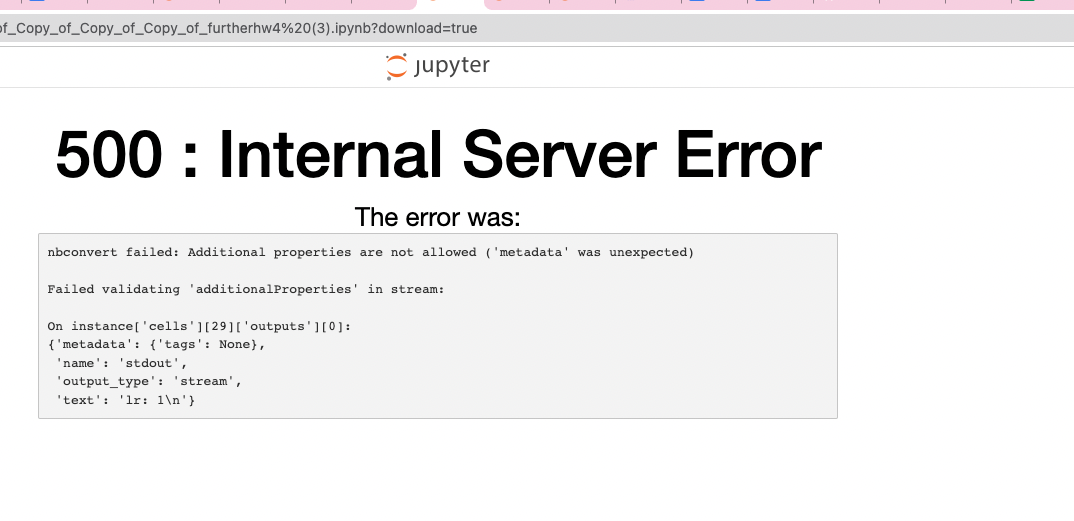

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

    

In [ ]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 350
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_20_T4.csv', append=True, separator=';')
n = 3

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_T4.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

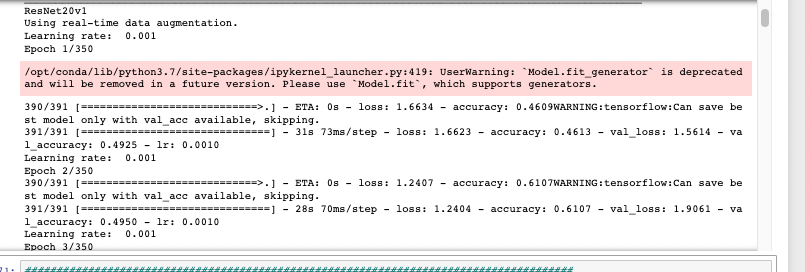

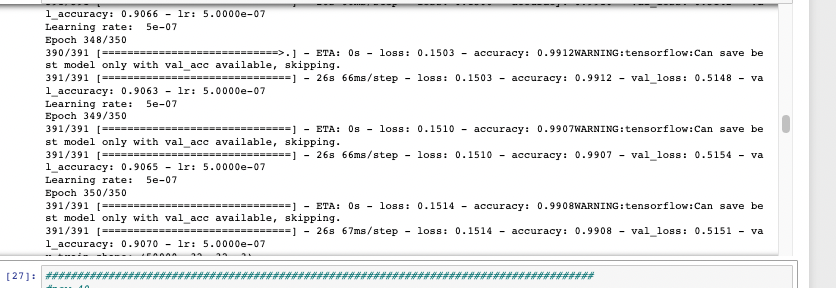

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_44_T4.csv', append=True, separator=';')
n = 7

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
Socks
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_T4.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

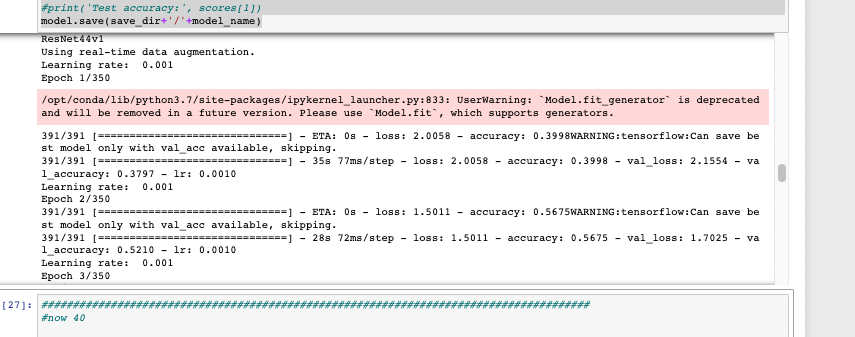

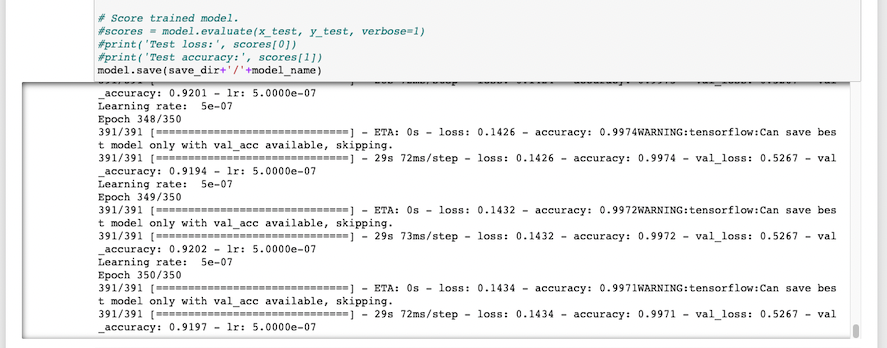

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_56_T4.csv', append=True, separator=';')
n = 9

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_T4.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

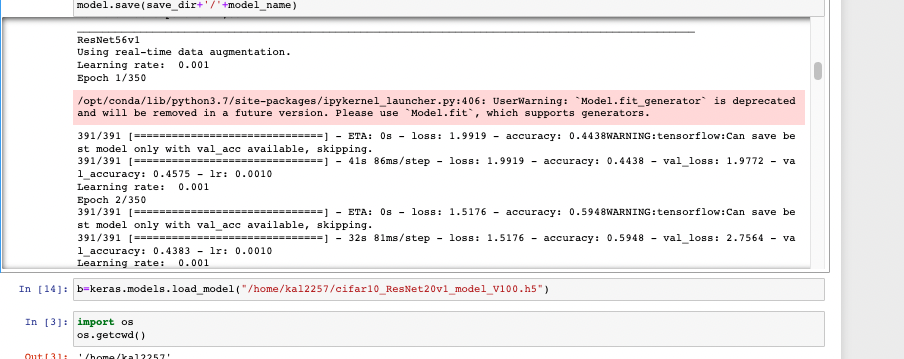

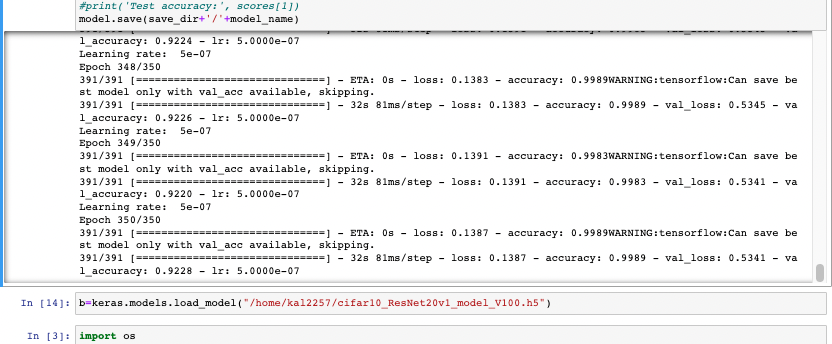

#### 2. We next study how the learned parameters, β0, β1, and β2, change with the type of GPUs and the size of network. Use a regression model on the data from 15 models to predict the value of these parameters as a function of number of layers in Resnet and GPU type. From these regresssion model predict the training loss curve for Resnet-50. Note that we are effectively doing prediction for a predictive model. To verify how good is this prediction, you will train Resnet-50 on a K80, P100, and V100 for target accuracy of 92% and compare the predicted loss curve with the real measurements. Show this comparison in a graph and calculate the percentage error. From the predicted loss curve get the number of epochs needed to achive 92% accuracy. Observe that there are three curves for three different GPU types, but the number of epochs required to reach a particular accuracy (convergence rate) should be independent of hardware. (8)

In [10]:
from sklearn import linear_model
from scipy.optimize import curve_fit
def f(k, beta0, beta1, beta2):
    b = 1 / (beta0 * k + beta1) + beta2
    return b

In [49]:
files=os.listdir(f'/content/gdrive/My Drive/hw4 question4 gpu/')
dir=f'/content/gdrive/My Drive/hw4 question4 gpu/'
import pandas as pd
results={}
failed=[] 
res50s=[]
for file1 in files:
  try:
    data = pd.DataFrame(pd.read_csv(dir+file1, sep=';'))
    file_orig=file1
    file1=file1.lower() 
    name=file1.rsplit('_', 2)
    gpu_type=name[-1].rsplit('.', 2)[0]
    data["GPU"]=gpu_type
    data["layers"]=name[-2]
    new=data[['GPU','epoch','loss',"accuracy","layers"]]
    new=new.groupby(['layers', 'GPU', 'epoch'])['loss'].mean()
    new=new.reset_index()
    betas, betas2 = curve_fit(f, xdata= new['epoch'].values, ydata=new['loss'].values, bounds=(0, 1))
    results[gpu_type,name[-2]]=betas
    results
    if name[-2] == '50':
      res50s=res50s+[new]
  except:
          failed=failed+[file_orig]

In [50]:
for file1 in failed:
  try:
    data = pd.DataFrame(pd.read_csv(dir+file1, sep=','))
    file1=file1.lower()
    name=file1.rsplit('_', 2)
    gpu_type=name[-1].rsplit('.', 2)[0]
    data["GPU"]=gpu_type
    data["layers"]=name[-2]
    new=data[['GPU','epoch','loss',"accuracy","layers"]]
    new=new.groupby(['layers', 'GPU', 'epoch'])['loss'].mean()
    new=new.reset_index()
    betas, betas2 = curve_fit(f, xdata= new['epoch'].values, ydata=new['loss'].values, bounds=(0, 1))
    results[gpu_type,name[-2]]=betas
    results
    if name[-2] == '50':
      res50s=res50s+[new]
  except:
    pass

In [30]:
vals=[]
for key, value in results.items():
  v100=0
  p100=0
  t4=0
  print(key[0])
  if str(key[0]).lower() == "v100":
    v100=1
  if str(key[0]).lower() == "p100":
    p100=1
  if str(key[0]).lower() == "t4":
    t4=1
  vals=vals+[[str(key[0]).lower(),str(key[1]).lower(),t4,p100,v100,value[0],value[1],value[2]]]
results=pd.DataFrame(vals,columns=["GPU","Layers","t4","p100","v100","beta0","beta1","beta2"])

v100
v100
v100
p100
p100
t4
v100
t4
t4
t4
v100
t4
p100
p100
p100
p100
v100
t4
[['v100', '20', 0, 0, 1, 0.0746303697510534, 0.7994082767015873, 0.10423219765302764], ['v100', '44', 0, 0, 1, 0.06793346174576487, 0.6740123380481574, 0.09157555727425902], ['v100', '56', 0, 0, 1, 0.06115745807139802, 0.7248269616957767, 0.0802666622686396], ['p100', '32', 0, 1, 0, 0.09217982588357815, 0.7557185551930223, 0.027936641523789413], ['p100', '20', 0, 1, 0, 0.12033934541668623, 0.7555063587987473, 0.03758620565947312], ['t4', '32', 1, 0, 0, 0.08410117003589081, 0.7728125237060827, 0.022357489811731617], ['v100', '32', 0, 0, 1, 0.0905885043163978, 0.7481296520843395, 0.023372537412955825], ['t4', '44', 1, 0, 0, 0.06556190297521372, 0.6822251341960116, 0.08892718687161756], ['t4', '20', 1, 0, 0, 0.0717064022915975, 0.8414149818157821, 0.09993453753168058], ['t4', '56', 1, 0, 0, 0.059710296270620154, 0.6608940295391464, 0.07930617489195037], ['v100', '50', 0, 0, 1, 0.05841524970776294, 0.711121853956

In [57]:
results

{('v100', '20'): array([0.07463037, 0.79940828, 0.1042322 ]),
 ('v100', '44'): array([0.06793346, 0.67401234, 0.09157556]),
 ('v100', '56'): array([0.06115746, 0.72482696, 0.08026666]),
 ('p100', '32'): array([0.09217983, 0.75571856, 0.02793664]),
 ('p100', '20'): array([0.12033935, 0.75550636, 0.03758621]),
 ('t4', '32'): array([0.08410117, 0.77281252, 0.02235749]),
 ('v100', '32'): array([0.0905885 , 0.74812965, 0.02337254]),
 ('t4', '44'): array([0.0655619 , 0.68222513, 0.08892719]),
 ('t4', '20'): array([0.0717064 , 0.84141498, 0.09993454]),
 ('t4', '56'): array([0.0597103 , 0.66089403, 0.07930617]),
 ('v100', '50'): array([0.05841525, 0.71112185, 0.07685913]),
 ('t4', '50'): array([0.06799353, 0.65172129, 0.08654812]),
 ('p100', '50'): array([0.06539461, 0.65520467, 0.08425657]),
 ('p100', '18'): array([2.65390867e-01, 6.10046008e-01, 1.78522378e-25]),
 ('p100', '44'): array([0.07039052, 0.67251597, 0.09194739]),
 ('p100', '56'): array([0.07097161, 0.59714059, 0.09302034]),
 ('v10

Predicted:

In [39]:
#predicted
no_50=results[results['Layers']!='50']
model = linear_model.LinearRegression()
model.fit(no_50[['Layers', 't4', 'p100', 'v100']].values, no_50[["beta0","beta1","beta2"]].values)
res50=np.array(
    [[50,1, 0, 0],[50, 0, 1, 0],[50, 0, 0, 1]])
model.predict(res50)

array([[0.05663709, 0.68854555, 0.08345064],
       [0.06869111, 0.65636385, 0.07639625],
       [0.05811359, 0.69409263, 0.08332274]])

Actual:

In [56]:
print(results[('v100','50')])
print(results[('p100','50')])
print(results[('t4','50')])

[0.05841525 0.71112185 0.07685913]
[0.06539461 0.65520467 0.08425657]
[0.06799353 0.65172129 0.08654812]


In [44]:
no_50

,GPU,Layers,t4,p100,v100,beta0,beta1,beta2
10,v100,50,0,0,1,0.058415,0.711122,0.076859
11,t4,50,1,0,0,0.067994,0.651721,0.086548
12,p100,50,0,1,0,0.065395,0.655205,0.084257


#### Now training the actual resnet 50
#**** Please see second notebook, q4q2 for logs for these questions. I have a wrist injury and can't keep copy pasting. Thank you.****

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n' .join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_50_V100.csv', append=True, separator=';')
n = 8

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_V100.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n' .join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_50_T4.csv', append=True, separator=';')
n = 8

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_T4.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

In [ ]:
#logger 
csv_logger = CSVLogger('/home/kal2257/log_50_P100.csv', append=True, separator=';')
n = 8

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = f'cifar10_%s_model_P100.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=epochs, verbose=1, workers=4,
                  callbacks=callbacks)

# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
model.save(save_dir+'/'+model_name)

Contributors: </br>
Jing Dong: resnet 18: p100, v100, t4; resnet 44 & 56: p100 </br>
Kristina Yuchen Tian: resnet 20: p100, v100; resnet 44 & 56: v100 </br>
Ganghua Mei : resnet 32: p100 , v100, t4 </br>
Kate Lassiter:  resnet 20 & 44 & 56: t4; resnet 20 on v100 </br>